In [3]:
 #Import all packages needed to analyze data
import scipy, numpy, cv2
import matplotlib as mpl
import matplotlib.style as style
import csv
from matplotlib import pyplot as plt

In [4]:
def csvsweep(pathbegin = '/home/devynn/Madagascar/'):
    """Sweeps GoPro Photo Lineup.csv and returns dict of photo names + approximate locations of them in a given video
    
    Optional Inputs:
        pathbegin: local path that leads to the /Madagascar2018 folder on dropbox
            (If you aren't on devynn's ubuntu subsystem, you will probably want to input a value for pathbegin)

    Outputs:
        videomapping: A dict containing keys of every GoPro image in the Madagascar2018 folders, whose values are lists
            containing, in order: the gopro video where the gopro frame may be found, the approximate frame location of
            the photo, and the folder in dropbox corresponding to the date the video was taken (e.g. 10-17, 10-20 etc.)

            Video name and video date are output as strings, approximate frame location is an int

    Videomapping is meant to feed into findframe function below
    """
    
    path = pathbegin + 'Madagascar2018/GoPro Photo Lineup.csv'
    csv_file = open(path)
    csv_reader = csv.reader(csv_file, delimiter =',')
    videomapping = {}
    for row in csv_reader:
        if row[0] == 'GoProVideoFiles': # Skip first row of csv bc it only contains column labels
            continue
        elif row[0]:
            videoname = row[0] # Grab video name
            folder = '-'.join(row[3].split(' ')) # Grab file location
        timesplit = row[2].split(':') # Split up 
        frame_approx = (int(timesplit[0])*3600+int(timesplit[1])*60+int(timesplit[2]))*24
        videomapping[row[1]] = [videoname, frame_approx, folder]

    return(videomapping)


In [ ]:
def findframe(images, pathbegin = '/home/devynn/Madagascar/', framecheck = 10, showgraph = True):
    """Function to find exact matching frame of a given image or list of images
    
    INPUTS:
        images: List of GoPro image files in string format to match to video frames.
        pathbegin (optional): Local path that leads to the /Madagascar2018 folder on dropbox
            (If you aren't on devynn's ubuntu subsystem, you will probably want to input a value for pathbegin)
        framecheck (optional): Number of frames to check around approximate image-frame location, as calculated by csvsweep
        showgraph (optional): Boolean value to toggle graphins frame-matching with matplotlib
    
    OUTPUTS:
        bestmatches: List of lists containing GoPro images and their keypoints, matched frames and their keypoints,
            a set of best matched points between the image and frame, the frame number, the image file name, and the video file name
    
    TO USE:
        -Import all packages according to the top cell in this notebook
        -Run csvsweep cell above
        -Run this cell, making sure the correct path to Madagascar2018 dropbox folder is input if necessary
    """
    
    # Establish path to Madagascar Dropbox Folder
    path = pathbegin + 'Madagascar2018/'
    
    # Run csvsweep to create dict of all photos and their approximate frame locations in corresponding videos
    videokey = csvsweep(pathbegin)
    
    bestmatches = []
    
    for img in images:
        # Raise error if image input not in dict, otherwise establish videopath, imagepath, frameguess
        if img in videokey:
            imagefile = img
            videofile = videokey[img][0]
            frameguess = videokey[img][1]
            videopath = path + videokey[img][2] + '/Bullfrog_camera/Stripped Audio/' + '_quiet.'.join(videofile.split('.'))
            imagepath = path + videokey[img][2] + '/Bullfrog_camera/' + img
            print(frameguess, videopath)
        else:
            raise NameError('Image ' + img  + ' Not Found. Did you mistype?')

        # Call video and image with openCV, resize and colorcorrect image
        video = cv2.VideoCapture(videopath)
        image = cv2.resize(cv2.cvtColor(cv2.imread(imagepath), cv2.COLOR_BGR2RGB), (1920, 1440))
        # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image_resize = cv2.resize(cv2.cvtColor(cv2.imread(imagepath), cv2.COLOR_BGR2RGB), (1920, 1440))

        # Create empty lists to store frames, keypoints, descriptors, matches, and means
        frameflag = frameguess
        frameset_colorcorrect = []
        kp = []
        des = []
        matches = []
        matches_means = []

        # Capture frames in range of csvsweeps' guessed frame location
        for i in range(frameflag + framecheck):
            rval, frame = cv2.VideoCapture.read(video)
            if i in range(frameflag - framecheck, frameflag + framecheck):
                frameset_colorcorrect.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        video.release()

        # Initiate ORB detector for feature matching
        orb = cv2.ORB_create()
        
        # Get keypoints and descriptors of GoPro Image, then for all captured frames
        kp_img, des_img = orb.detectAndCompute(image, None)

        for i in range(len(frameset_colorcorrect)):
            kp_vid, des_vid = orb.detectAndCompute(frameset_colorcorrect[i], None)
            kp.append(kp_vid)
            des.append(des_vid)

        # Make BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match Descriptors
        for i in range(len(des)):
            matches.append(bf.match(des_img,des[i]))
            matches[-1] = sorted(matches[-1], key = lambda x:x.distance)
            matches_means.append(sum(m.distance for m in matches[-1])/len(matches[-1]))

        # Find frame with minimum difference from GoPro image and log that frame
        framestop = matches_means.index(min(matches_means))
        matchset = matches[framestop]
        exactframe = framestop+frameflag-framecheck
        
        # Append list to bestmatches containing image, keypoints, frame, matches, frame number, image and video filenames
        bestmatches.append([image, kp_img, frameset_colorcorrect[framestop], 
                            kp[framestop], matchset, exactframe, imagefile, videofile])
        
    # Graph everything
    if showgraph is True:
        mpl.rcParams['figure.figsize'] = [16.0, 12.0]

        for image_video_pair in range(len(bestmatches)):
            dataset = bestmatches[image_video_pair]
            matched_image = dataset[0]
            matched_kp_img = dataset[1]
            matched_frame = dataset[2]
            matched_kp_frame = dataset[3]
            matched_matches = dataset[4]
            framename = dataset[5]
            imagename = dataset[6]
            videoname = dataset[7]
            imagematches = cv2.drawMatches(matched_image, matched_kp_img, 
                                           matched_frame, matched_kp_frame, matched_matches[:20], None, flags=2)
            plt.subplot(len(bestmatches), 1, image_video_pair+1)
            plt.imshow(imagematches)
            plt.title(imagename + ' matched with frame ' + str(framename) + ' of video ' + videoname)

    return(bestmatches)

matcher = findframe(['G0434150.JPG', 'G0332856.JPG'])

In [ ]:
# Code below this cell is old and probably not necessary

In [44]:
PATH1 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/G0192070.JPG'
PATH2 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/Stripped Audio/GOPR2025_quiet.MP4'

img = cv2.imread(PATH1)
vid = cv2.VideoCapture(PATH2)

Text(0.5,1,'Video Stream Capture')

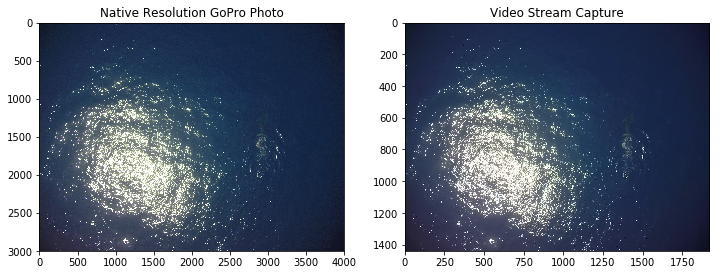

In [45]:
#Convert BGR to RBG
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Capture correct video frame
vid = cv2.VideoCapture(PATH2)
frameflag = 5399
count = 0

while(True):
    rval, frame = cv2.VideoCapture.read(vid)
    if count == frameflag:
        break
    count +=1
vid.release()

#Plot Everything
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Native Resolution GoPro Photo')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Video Stream Capture')


Text(0.5,1,'Video Stream Capture')

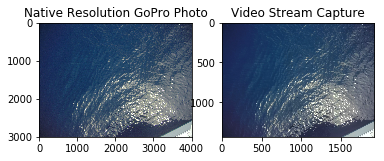

In [2]:
# Something about GoPro audio codec causes all videos to briefly return False for 20-80 frames, starting at the 16th frame
# Stripping audio from the .mp4 file using ffmpeg fixes the problem. Why was this ever a problem tho

PATH3 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/G0171996.JPG'
img2 = cv2.imread(PATH3)

PATH4 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/GOPR1968.MP4'
vid2 = cv2.VideoCapture(PATH4)

frameflag = 3357 + 26
count = 0

while(True):
    rval, frame = cv2.VideoCapture.read(vid2)
    if count == frameflag:
        break
    count +=1
vid2.release()

frame_colorcorrect = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(img2_rgb)
plt.title('Native Resolution GoPro Photo')
plt.subplot(1, 2, 2)
plt.imshow(frame_colorcorrect)
plt.title('Video Stream Capture')

<generator object <genexpr> at 0x7f9e6f519258>


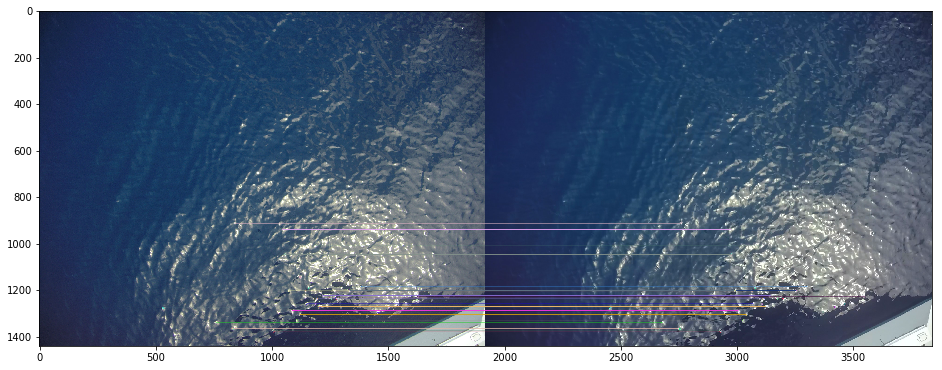

In [3]:
#Downsize img2_rgb to the same size as frame_colorcorrect
img2_resize = cv2.resize(img2_rgb, (1920, 1440))

#Brute-force matcher tests from docs.opencv.org. Uses img2_resize and frame_colorcorrect from above

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img2_resize, None)
kp2, des2 = orb.detectAndCompute(frame_colorcorrect, None)

# create BF Matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
matches = bf.match(des1,des2)

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

print(m.distance for m in matches)

# Draw first 20 matches
imagematches = cv2.drawMatches(img2_resize, kp1, frame_colorcorrect, kp2, matches[:40], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

mpl.rcParams['figure.figsize'] = [16.0, 12.0]
plt.imshow(imagematches)

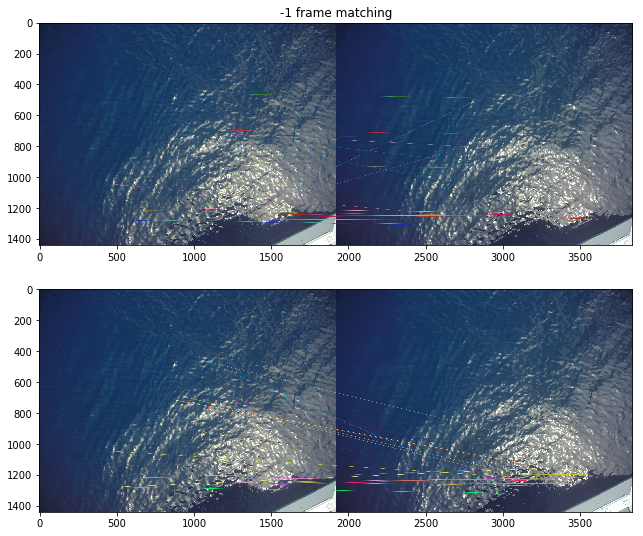

In [113]:
#Brute-force matcher tests, using -1 frame amd +1 frame

orb = cv2.ORB_create()
before_colcorr = cv2.cvtColor(beforeframe, cv2.COLOR_BGR2RGB)

kp3, des3 = orb.detectAndCompute(img2_resize, None)
kp4, des4 = orb.detectAndCompute(before_colcorr, None)

# create BF Matcher object
bf2 = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
matches2 = bf2.match(des3,des4)

# Sort them in the order of their distance
matches2_ordered = sorted(matches2, key = lambda x:x.distance)

# Draw first 20 matches
imagematches2 = cv2.drawMatches(img2_resize, kp3, before_colcorr, kp4, matches2_ordered[:20], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

after_colcorr = cv2.cvtColor(afterframe, cv2.COLOR_BGR2RGB)

kp5, des5 = orb.detectAndCompute(img2_resize, None)
kp6, des6 = orb.detectAndCompute(after_colcorr, None)

# create BF Matcher object
bf3 = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
matches3 = bf3.match(des3,des4)

# Sort them in the order of their distance
matches3 = sorted(matches3, key = lambda x:x.distance)

# Draw first 20 matches
imagematches3 = cv2.drawMatches(img2_resize, kp5, after_colcorr, kp6, matches3[:20], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

plt.subplot(2,1,1)
plt.imshow(imagematches2)
plt.title('-1 frame matching')
plt.subplot(2,1,2)
plt.imshow(imagematches3)
plt.title('+1 frame matching')
plt.show()

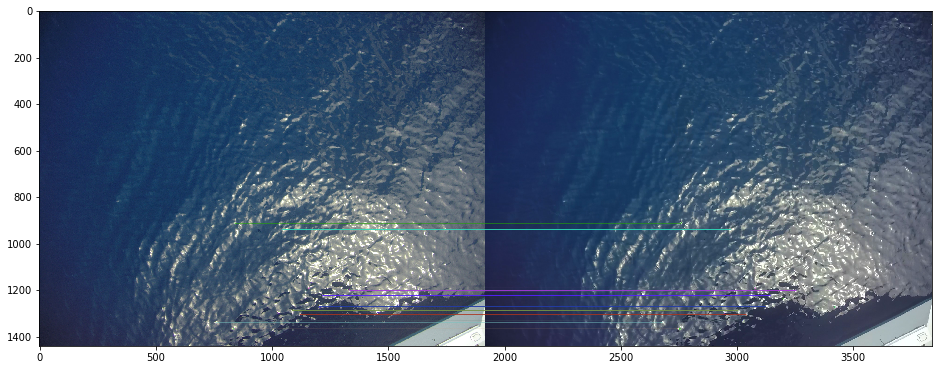

In [68]:
#This method can be used with other images and videos in the dropbox folders
#FRAME OFFSET IS DUE TO GOPRO AUDIO CODEC ISSUES: can be resolved by stripping audio stream using ffmpeg

PATH3 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/G0171996.JPG'
img2 = cv2.imread(PATH3)

PATH4 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/GOPR1968.MP4'
vid2 = cv2.VideoCapture(PATH4)

frameflag = 3357+26
count = 0
frameset = []
frameset_colorcorrect = []
framecheck = 5
kps = []
des = []
matches = []
matches_means = []

while(True):
    rval, frame = cv2.VideoCapture.read(vid2)
    if count in range(frameflag - framecheck, frameflag + framecheck):
        frameset.append(frame)
    if count == frameflag + framecheck:
        break
    count +=1
vid2.release()

img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

for i in range(len(frameset)):
    frameset_colorcorrect.append(cv2.cvtColor(frameset[i], cv2.COLOR_BGR2RGB))

#Downsize img2_rgb to the same size as frame_colorcorrect
img2_resize = cv2.resize(img2_rgb, (1920, 1440))

#Brute-force matcher tests from docs.opencv.org. Uses img2_resize and frame_colorcorrect from above

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img2_resize, None)

for i in range(len(frameset)):
    kp2, des2 = orb.detectAndCompute(frameset_colorcorrect[i], None)
    kps.append(kp2)
    des.append(des2)
    
# create BF Matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
for i in range(len(des)):
    matches.append(bf.match(des1,des[i]))
    matches[-1] = sorted(matches[-1], key = lambda x:x.distance)
    matches_means.append(sum(m.distance for m in matches[-1])/len(matches[-1]))
    
framestop = matches_means.index(min(matches_means))
match_fstop = matches[framestop]
# Sort them in the order of their distance
#matches = sorted(matches, key = lambda x:x.distance)
#matches3 = matches[3]
#print(m.distance for m in matches)

# Draw first 20 matches
imagematches = cv2.drawMatches(img2_resize, kp1, frameset_colorcorrect[framestop], kps[framestop], match_fstop[:20], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

#mpl.rcParams['figure.figsize'] = [16.0, 12.0]
plt.imshow(imagematches)

5446


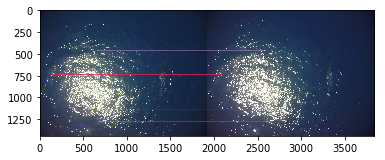

In [22]:
#Same code as above, different paths, different frame flags. Still seems to work fine

PATH3 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/G0192070.JPG'
img2 = cv2.imread(PATH3)

PATH4 = '/mnt/c/Users/Devynn/Dropbox (Point Road Solutions)/PRS_Engineering/Madagascar2018/10-20/Bullfrog_camera/GOPR2025.MP4'
vid2 = cv2.VideoCapture(PATH4)

frameflag = 5399+50
count = 0
frameset = []
frameset_colorcorrect = []
framecheck = 5
kps = []
des = []
matches = []
matches_means = []

while(True):
    rval, frame = cv2.VideoCapture.read(vid2)
    if count in range(frameflag - framecheck, frameflag + framecheck):
        frameset.append(frame)
    if count == frameflag + framecheck:
        break
    count +=1
vid2.release()

img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

for i in range(len(frameset)):
    frameset_colorcorrect.append(cv2.cvtColor(frameset[i], cv2.COLOR_BGR2RGB))

#Downsize img2_rgb to the same size as frame_colorcorrect
img2_resize = cv2.resize(img2_rgb, (1920, 1440))

#Brute-force matcher tests from docs.opencv.org. Uses img2_resize and frame_colorcorrect from above

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img2_resize, None)

for i in range(len(frameset)):
    kp2, des2 = orb.detectAndCompute(frameset_colorcorrect[i], None)
    kps.append(kp2)
    des.append(des2)
    
# create BF Matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match Descriptors
for i in range(len(des)):
    matches.append(bf.match(des1,des[i]))
    matches[-1] = sorted(matches[-1], key = lambda x:x.distance)
    matches_means.append(sum(m.distance for m in matches[-1])/len(matches[-1]))
    
framestop = matches_means.index(min(matches_means))
match_fstop = matches[framestop]
print(framestop+frameflag-framecheck)
# Sort them in the order of their distance
#matches = sorted(matches, key = lambda x:x.distance)
#matches3 = matches[3]
#print(m.distance for m in matches)

# Draw first 20 matches
imagematches = cv2.drawMatches(img2_resize, kp1, frameset_colorcorrect[framestop], kps[framestop], match_fstop[:20], None, flags=2)
# Tutorial code excludes None in pos 6 but appears to be necessary after following a stackoverflow thread on the topic

#mpl.rcParams['figure.figsize'] = [16.0, 12.0]
plt.imshow(imagematches)